In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import pandas as pd

import ecephys_analyses as ea 
from ecephys.plot import plot_hypnogram_overlay

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [3]:
from itertools import zip_longest

def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

In [4]:
xr.set_options(keep_attrs=True)

In [62]:
subject = 'Allan'
experiment = 'sleep-homeostasis'
condition = 'light-period-circadian-match'

In [63]:
hyp = ea.load_hypnogram(subject, experiment, condition)
spws = ea.load_spws(subject, experiment, condition, abs_sink=True)

In [64]:
def is_divisible(dividend, divisor):
    return pd.to_timedelta(dividend) % pd.to_timedelta(divisor) == pd.to_timedelta(0)

def as_interval(interval_index):
    return pd.Interval(interval_index.min().left, interval_index.max().right)

def get_overlapping_intervals(start, stop, interval_length, overlap_length):
    assert is_divisible(interval_length, overlap_length)
    chunks_per_interval = pd.to_timedelta(interval_length) // pd.to_timedelta(overlap_length)
    chunks = pd.interval_range(start, stop, freq=overlap_length)
    n_intervals = len(chunks) - chunks_per_interval + 1
    intervals = [as_interval(chunks[i:i + chunks_per_interval]) for i in range(n_intervals)]
    return pd.IntervalIndex(intervals)

In [65]:
intervals = get_overlapping_intervals(hyp.start_time.min(), hyp.end_time.max(), '15T', '1T')

In [66]:
def get_pre_post_differences(spws, interval):
    pre, post = pd.interval_range(interval.left, interval.right, periods=2)
    spws_pre = spws.set_index('start_time').between_time(pre.left.time(), pre.right.time())
    spws_post = spws.set_index('start_time').between_time(post.left.time(), post.right.time())
    diff = spws_pre.mean() - spws_post.mean()
    diff['spws'] = len(spws_pre) - len(spws_post)
    diff['window_center'] = interval.mid
    return diff

In [67]:
diffs = list(map(lambda interval: get_pre_post_differences(spws, interval), intervals))

/home/gfindlay/miniconda3/envs/ecephys/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """


In [68]:
df = pd.DataFrame(diffs)

<AxesSubplot:xlabel='duration', ylabel='Count'>

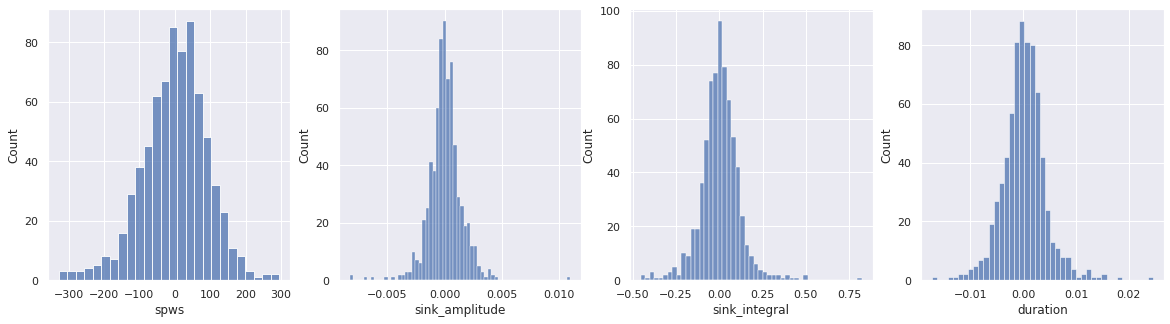

In [69]:
n_plots, height, aspect = (4, 5, 1)
fig, axes = plt.subplots(1, n_plots, figsize=(n_plots * height * aspect, height))
sns.histplot(data=df.spws, ax=axes[0])
sns.histplot(data=df.sink_amplitude, ax=axes[1])
sns.histplot(data=df.sink_integral, ax=axes[2])
sns.histplot(data=df.duration, ax=axes[3])

In [70]:
def plot_timeseries(df, y_var, ax, fill):
    x_var = 'window_center'
    s = 0.1 if fill else 2
    sns.scatterplot(data=df, x=x_var, y=y_var, color='black', s=s, ax=ax)
    if fill:
        ax.fill_between(df[x_var], df[y_var], color='black')
    
    return ax

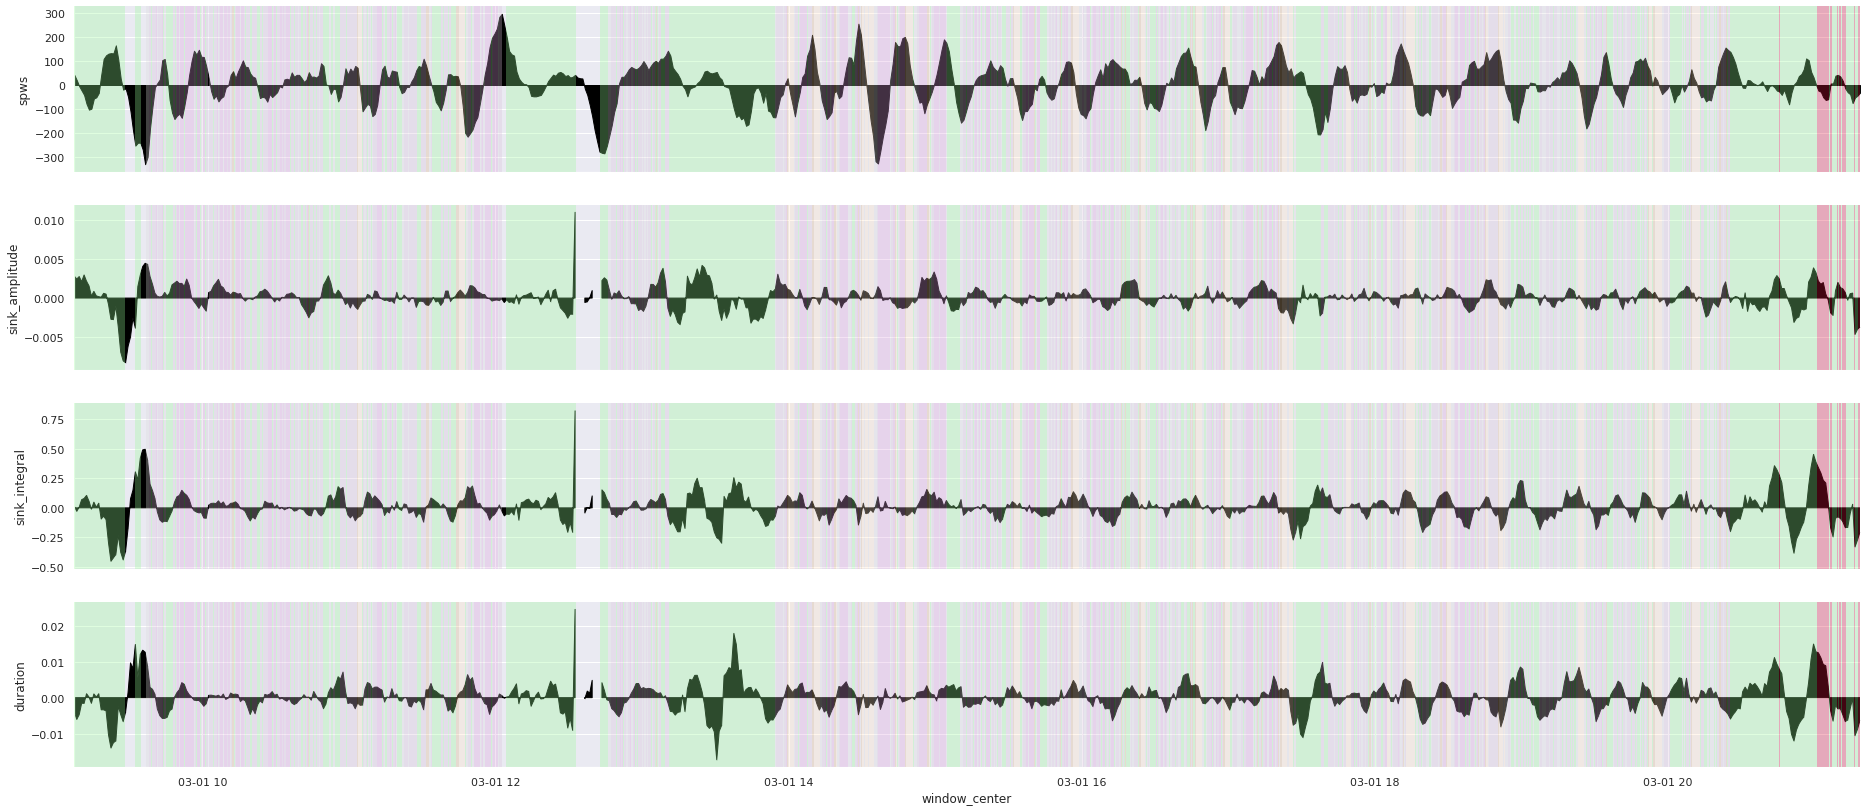

In [71]:
fig, axes = plt.subplots(4, 1, figsize=(32, 14))
plot_timeseries(df, 'spws', axes[0], True)
plot_timeseries(df, 'sink_amplitude', axes[1], True)
plot_timeseries(df, 'sink_integral', axes[2], True)
plot_timeseries(df, 'duration', axes[3], True)

for ax in axes:
    ax.set(xmargin=0)
    plot_hypnogram_overlay(hyp, ax=ax)
    if ax != axes[-1]:
        ax.set(xlabel=None, xticklabels=[])
    
sns.despine()